<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

In [3]:
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

In [4]:
import mltle as mlt

Done.


In [7]:
SEED = 7

NUM_RES_BLOCKS = 1
GRAPH_DEPTH = 4
GRAPH_FEATURES = 'g78'
GRAPH_TYPE = 'gcn'
NORMALIZE = True
NORMALIZATION_TYPE = 'kipf'
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 1024

data_path_1 = '../data/data_pKd/'
data_path_2 = '../data/data_pEC50/'
data_type_1 = 'pKd'
data_type_2 = 'pEC50'
model_name = f'Res1GCN4_{data_type_1}_{data_type_2}'

In [8]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.graph_training.GraphModel(protein_emb_size=64, protein_alphabet_len=8006)

order = ['pKi', 'pIC50', 'pKd', 'pEC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(
    variables, discount=DISCOUNT, decay=0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type_1: [mlt.training_utils.cindex_score], 
              data_type_2: [mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations['qed'] = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                           activations=activations,
                           activation='relu',
                           pooling_mode='max',
                           num_res_blocks=NUM_RES_BLOCKS,
                           units_per_head=64,
                           units_per_layer=1024,
                           dropout_rate=0.3,
                           protein_kernel=(7, 7),
                           loss_weights=loss_weights,
                           usemetrics=usemetrics,
                           uselosses=uselosses,
                           initializer=initializer,
                           optimizer=optimizer,
                           protein_strides_down=1,
                           graph_depth=GRAPH_DEPTH,
                           num_graph_features=78,
                           graph_type=GRAPH_TYPE)

2022-08-22 11:26:18.141665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 11:26:18.142278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 11:26:18.142665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 11:26:18.142928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Done. Total trainable params: 2627895


In [ ]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [10]:
X_train_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_train.csv")[['smiles', 'target'] + order]
X_valid_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_valid.csv")[['smiles', 'target'] + order]
X_test_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_test.csv")[['smiles', 'target'] + order]

X_train_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_train.csv")[['smiles', 'target'] + order]
X_valid_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_valid.csv")[['smiles', 'target'] + order]
X_test_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_test.csv")[['smiles', 'target'] + order]

X_train = X_train_1.append(X_train_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
X_valid = X_valid_1.append(X_valid_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
X_test = X_test_1.append(X_test_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)


X_train.head(2)

/tmp/ipykernel_5032/161696158.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train_1.append(X_train_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
/tmp/ipykernel_5032/161696158.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_valid = X_valid_1.append(X_valid_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
/tmp/ipykernel_5032/161696158.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test_1.append(X_test_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)


,smiles,target,pKi,pIC50,pKd,pEC50,is_active,qed,pH
16388,COc1ccc(OC)c2nc3c(C(=O)NCCN(C)C)cccc3nc12,MSTPTDPGAMPHPGPSPGPGPSPGPILGPSPGPGPSPGSVHSMMGP...,NaN,NaN,NaN,4.990970,0.0,0.683298,NaN
25058,O=C(COc1ncnc2ccccc12)c1ccc2c(c1)OCCO2,MDYSYDEDLDELCPVCGDKVSGYHYGLLTCESCKGFFKRTVQNNKH...,NaN,NaN,NaN,6.402195,1.0,0.687829,NaN


In [11]:
mapseq = mlt.datamap.MapSeq(drug_mode=GRAPH_FEATURES,
                            protein_mode='protein_3',
                            max_drug_len=100,
                            max_protein_len=1000,
                            graph_normalize=NORMALIZE,
                            graph_normalization_type=NORMALIZATION_TYPE)

drug_seqs = np.hstack((X_train['smiles'].unique(), X_valid['smiles'].unique(), X_test['smiles'].unique()))
protein_seqs = np.hstack((X_train['target'].unique(), X_valid['target'].unique(), X_test['target'].unique()))

map_drug, map_protein = mapseq.create_maps(drug_seqs=drug_seqs,
                                           protein_seqs=protein_seqs)

  0%|          | 0/69368 [00:00<?, ?it/s]

  0%|          | 0/2699 [00:00<?, ?it/s]

In [12]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein, drug_graph_mode=True)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein, drug_graph_mode=True, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [13]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [14]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_loss',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [15]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-08-22 11:28:33.403672: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-22 11:28:33.568438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-22 11:28:34.795010: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 11:28:34.795306: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 11:28:34.795332: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-22 11:28:34.795629: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 11:28:34.795694: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to


Epoch 1: val_loss improved from inf to 51.32341, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 2: val_loss improved from 51.32341 to 29.10287, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 3: val_loss improved from 29.10287 to 19.64174, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 4: val_loss improved from 19.64174 to 15.31551, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 5: val_loss improved from 15.31551 to 13.12228, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 6: val_loss improved from 13.12228 to 12.47501, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 7: val_loss improved from 12.47501 to 11.09170, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 8: val_loss improved from 11.09170 to 10.82047, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 9: val_loss improved from 10.82047 to 8.27042, saving model to Best_Res1GCN4_pKd_pEC50.h5

Epoch 10: val_loss did not improve from 8.27042

Epoch 11: val_loss improved from 8.27042 to 7.03880, saving model to Best_


Epoch 134: val_loss did not improve from 1.83941

Epoch 135: val_loss did not improve from 1.83941

Epoch 136: val_loss did not improve from 1.83941

Epoch 137: val_loss did not improve from 1.83941

Epoch 138: val_loss did not improve from 1.83941

Epoch 139: val_loss did not improve from 1.83941

Epoch 140: val_loss did not improve from 1.83941

Epoch 141: val_loss did not improve from 1.83941

Epoch 142: val_loss did not improve from 1.83941

Epoch 143: val_loss did not improve from 1.83941

Epoch 144: val_loss did not improve from 1.83941

Epoch 145: val_loss did not improve from 1.83941

Epoch 146: val_loss did not improve from 1.83941

Epoch 147: val_loss did not improve from 1.83941

Epoch 148: val_loss did not improve from 1.83941

Epoch 149: val_loss did not improve from 1.83941

Epoch 150: val_loss did not improve from 1.83941

Epoch 151: val_loss did not improve from 1.83941

Epoch 152: val_loss did not improve from 1.83941

Epoch 153: val_loss did not improve from 1.83941



Epoch 298: val_loss did not improve from 1.83941

Epoch 299: val_loss did not improve from 1.83941

Epoch 300: val_loss did not improve from 1.83941

Epoch 301: val_loss did not improve from 1.83941

Epoch 302: val_loss did not improve from 1.83941

Epoch 303: val_loss did not improve from 1.83941

Epoch 304: val_loss did not improve from 1.83941

Epoch 305: val_loss did not improve from 1.83941

Epoch 306: val_loss did not improve from 1.83941

Epoch 307: val_loss did not improve from 1.83941

Epoch 308: val_loss did not improve from 1.83941

Epoch 309: val_loss did not improve from 1.83941

Epoch 310: val_loss did not improve from 1.83941

Epoch 311: val_loss did not improve from 1.83941

Epoch 312: val_loss did not improve from 1.83941

Epoch 313: val_loss did not improve from 1.83941

Epoch 314: val_loss did not improve from 1.83941

Epoch 315: val_loss did not improve from 1.83941

Epoch 316: val_loss did not improve from 1.83941

Epoch 317: val_loss did not improve from 1.83941



Epoch 462: val_loss did not improve from 1.83941

Epoch 463: val_loss did not improve from 1.83941

Epoch 464: val_loss did not improve from 1.83941

Epoch 465: val_loss did not improve from 1.83941

Epoch 466: val_loss did not improve from 1.83941

Epoch 467: val_loss did not improve from 1.83941

Epoch 468: val_loss did not improve from 1.83941

Epoch 469: val_loss did not improve from 1.83941

Epoch 470: val_loss did not improve from 1.83941

Epoch 471: val_loss did not improve from 1.83941

Epoch 472: val_loss did not improve from 1.83941

Epoch 473: val_loss did not improve from 1.83941

Epoch 474: val_loss did not improve from 1.83941

Epoch 475: val_loss did not improve from 1.83941

Epoch 476: val_loss did not improve from 1.83941

Epoch 477: val_loss did not improve from 1.83941

Epoch 478: val_loss did not improve from 1.83941

Epoch 479: val_loss did not improve from 1.83941

Epoch 480: val_loss did not improve from 1.83941

Epoch 481: val_loss did not improve from 1.83941



Epoch 626: val_loss did not improve from 1.83941

Epoch 627: val_loss did not improve from 1.83941

Epoch 628: val_loss did not improve from 1.83941

Epoch 629: val_loss did not improve from 1.83941

Epoch 630: val_loss did not improve from 1.83941

Epoch 631: val_loss did not improve from 1.83941

Epoch 632: val_loss did not improve from 1.83941

Epoch 633: val_loss did not improve from 1.83941

Epoch 634: val_loss did not improve from 1.83941

Epoch 635: val_loss did not improve from 1.83941

Epoch 636: val_loss did not improve from 1.83941

Epoch 637: val_loss did not improve from 1.83941

Epoch 638: val_loss did not improve from 1.83941

Epoch 639: val_loss did not improve from 1.83941

Epoch 640: val_loss did not improve from 1.83941

Epoch 641: val_loss did not improve from 1.83941

Epoch 642: val_loss did not improve from 1.83941

Epoch 643: val_loss did not improve from 1.83941

Epoch 644: val_loss did not improve from 1.83941

Epoch 645: val_loss did not improve from 1.83941



Epoch 790: val_loss did not improve from 1.83941

Epoch 791: val_loss did not improve from 1.83941

Epoch 792: val_loss did not improve from 1.83941

Epoch 793: val_loss did not improve from 1.83941

Epoch 794: val_loss did not improve from 1.83941

Epoch 795: val_loss did not improve from 1.83941

Epoch 796: val_loss did not improve from 1.83941

Epoch 797: val_loss did not improve from 1.83941

Epoch 798: val_loss did not improve from 1.83941

Epoch 799: val_loss did not improve from 1.83941

Epoch 800: val_loss did not improve from 1.83941

Epoch 801: val_loss did not improve from 1.83941

Epoch 802: val_loss did not improve from 1.83941

Epoch 803: val_loss did not improve from 1.83941

Epoch 804: val_loss did not improve from 1.83941

Epoch 805: val_loss did not improve from 1.83941

Epoch 806: val_loss did not improve from 1.83941

Epoch 807: val_loss did not improve from 1.83941

Epoch 808: val_loss did not improve from 1.83941

Epoch 809: val_loss did not improve from 1.83941



Epoch 954: val_loss did not improve from 1.83941

Epoch 955: val_loss did not improve from 1.83941

Epoch 956: val_loss did not improve from 1.83941

Epoch 957: val_loss did not improve from 1.83941

Epoch 958: val_loss did not improve from 1.83941

Epoch 959: val_loss did not improve from 1.83941

Epoch 960: val_loss did not improve from 1.83941

Epoch 961: val_loss did not improve from 1.83941

Epoch 962: val_loss did not improve from 1.83941

Epoch 963: val_loss did not improve from 1.83941

Epoch 964: val_loss did not improve from 1.83941

Epoch 965: val_loss did not improve from 1.83941

Epoch 966: val_loss did not improve from 1.83941

Epoch 967: val_loss did not improve from 1.83941

Epoch 968: val_loss did not improve from 1.83941

Epoch 969: val_loss did not improve from 1.83941

Epoch 970: val_loss did not improve from 1.83941

Epoch 971: val_loss did not improve from 1.83941

Epoch 972: val_loss did not improve from 1.83941

Epoch 973: val_loss did not improve from 1.83941


In [16]:
[f"{k} : {float(v)}" for k, v in variables.items()]

['pKi : 0.0',
 'pIC50 : 0.0',
 'pKd : 0.0',
 'pEC50 : 0.0',
 'is_active : 0.0',
 'qed : 0.0',
 'pH : 0.0']

In [17]:
model.load_weights(best_model_path)
model.compile()
model.save(f"{model_name}.hdf5")

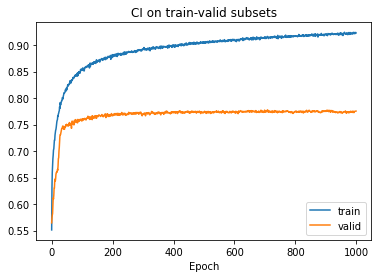

In [18]:
plt.plot(history.history[f'{data_type_1}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type_1}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

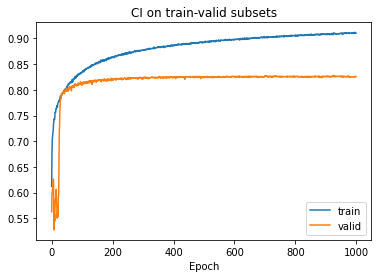

In [19]:
plt.plot(history.history[f'{data_type_2}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type_2}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

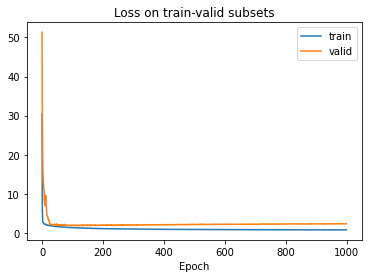

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [21]:
test_batch_size = mlt.training_utils.get_batch_size(X_test.shape[0])
test_batch_size

91

In [22]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True, 
                               drug_graph_mode=True)

test_gen = test_gen.get_generator(test_batch_size)

In [23]:
prediction = model.predict(test_gen,
                           steps=X_test.shape[0] // test_batch_size,
                           verbose=1)

305/305 [==============================] - 16s 50ms/step


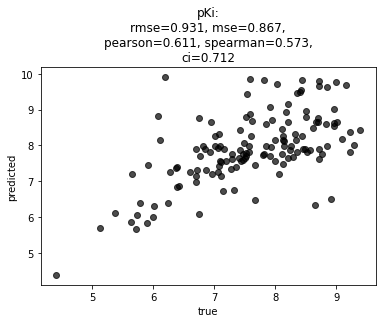

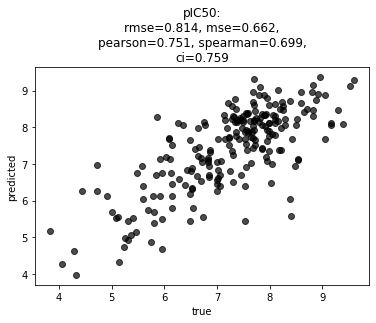

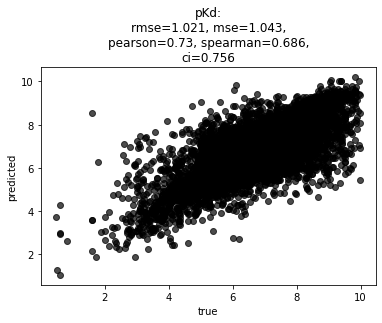

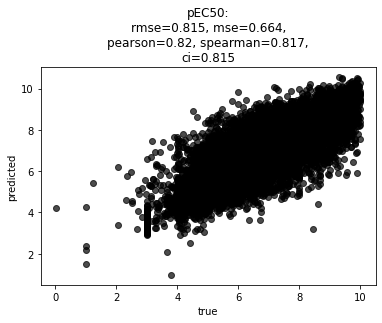

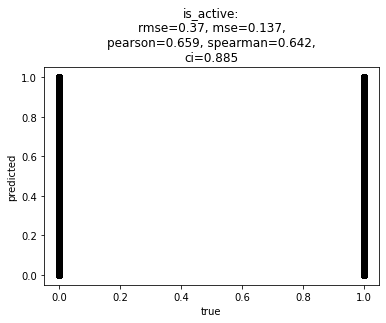

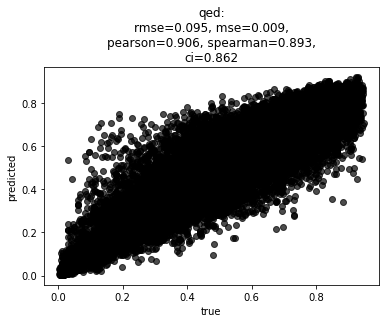

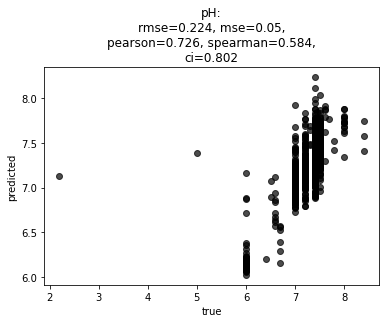

In [24]:
for k, col in enumerate(order):
    try:
        plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = X_test[col][X_test[col].notna()]
        y_pred = prediction[k][X_test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(f'Empty set test set for: {col}, values sum = {X_test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {X_test[col].notna().sum()}')

In [25]:
P = prediction[order.index(data_type_1)].ravel().tolist()
G = X_test[data_type_1].values.tolist()

In [26]:
with open(f'test_{data_type_1}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")

In [27]:
P = prediction[order.index(data_type_2)].ravel().tolist()
G = X_test[data_type_2].values.tolist()

In [28]:
with open(f'test_{data_type_2}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")